In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import random
from scipy.optimize import minimize
import prettytable
import plotly.graph_objects as go
import os
import math
import plotly.express as px

random.seed(0) # Setting random seed to 0
%matplotlib inline


### Sustainable and Entrepreneurial Finance

### Assignment 2 - Portfolio decarbonization

#### Group 8 - Energy Firms With Available Scope 1 to 3 emissions (TRUCOST)

- Charlotte Ahrens
- David Campbell
- Guillaume Rico
- Per Christian Wessel


### 0 Importing and preparing datasets

In [2]:
# Setting path names
github_path = 'https://github.com/percw/Sustainable_and_Entrepreneurial_Finance/blob/master'

# Scope 1-3 Intensity Paths
path_scope1_intensity = f'{github_path}/Data_Excel/Trucost_CO2emissions/scope1intensity.xlsx?raw=true'
path_scope2_intensity = f'{github_path}/Data_Excel/Trucost_CO2emissions/scope2intensity.xlsx?raw=true'
path_scope3_intensity = f'{github_path}/Data_Excel/Trucost_CO2emissions/scope3intensity.xlsx?raw=true'

# Reading df's
df_scope1_intensity = pd.read_excel(path_scope1_intensity)
df_scope2_intensity = pd.read_excel(path_scope2_intensity)
df_scope3_intensity = pd.read_excel(path_scope3_intensity)

# Dataframe created during Homework 1 (corresponding to Q2 First df)
path_all_energy_monthly_yearly_returns_cap = f'{github_path}/output/all_energy_monthly_yearly_returns_cap.csv?raw=true'
df_all_energy_monthly_yearly_returns_cap = pd.read_csv(path_all_energy_monthly_yearly_returns_cap)

# Dataframe created during Homework 1 (corresponding to Q2 Second, comparison df with value weighted and equally weighted portfolio)
path_all_energy_monthly_yearly_returns_cap_vw = f'{github_path}/output/df_all_energy_monthly_yearly_returns_cap_vw.csv?raw=true'
df_all_energy_monthly_yearly_returns_cap_vw = pd.read_csv(path_all_energy_monthly_yearly_returns_cap_vw)


A little cleaning of the double index column, thus removing `Unnamed: 0`.

In [3]:
df_all_energy_monthly_yearly_returns_cap.drop(columns={'Unnamed: 0'}, inplace=True)
display(df_all_energy_monthly_yearly_returns_cap.head())

,date,year,month,ISIN,monthly_return,market_cap,annual_returns
0,2005-01-31,2005,1,AN8068571086,0.012603,NaN,0.468026
1,2005-02-28,2005,2,AN8068571086,0.063502,NaN,0.468026
2,2005-03-31,2005,3,AN8068571086,0.093039,NaN,0.468026
3,2005-04-30,2005,4,AN8068571086,-0.038401,NaN,0.468026
4,2005-05-31,2005,5,AN8068571086,-0.027085,NaN,0.468026


Checking out the intensity data and removing the x in the column name

In [4]:
df_scope1_intensity.describe()

# Replacing the x before every year
df_scope1_intensity.columns = df_scope1_intensity.columns.str.replace('x','')
display(df_scope1_intensity.head())
display(df_scope1_intensity.shape)
df_scope1_intensity.isna().sum()

,ISIN,NAME,1999,2000,2001,2002,2003,2004,2005,2006,...,2011,2012,2013,2014,2015,2016,2017,2018,2019,2020
0,AEA000201011,ABU DHABI COML.BANK,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,0.635512,0.608883,0.628201,0.570183,0.549080,0.441011,0.393496,NaN
1,AEA000701010,WAHA CAPITAL,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,19.195644,18.841809,18.853956,18.332604,17.847808,17.351218,17.575886,NaN
2,AEA000801018,ABU DHABI ISLAMIC BANK,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.994607,0.898398,NaN
3,AEA001201010,AMLAK FINANCE,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,0.538608,5.759130,6.638521,5.603768,NaN
4,AEA001501013,ARABTEC HOLDING SUSP - SUSP.30/09/20,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,26.474273,24.962883,25.033033,24.432088,124.414586,63.504253,61.421360,NaN


(17610, 24)

ISIN        0
NAME        0
1999    17610
2000    17610
2001    17610
2002    17610
2003    17610
2004    17610
2005    13854
2006    13571
2007    13435
2008    13455
2009    13168
2010    12997
2011    12897
2012    12860
2013    11982
2014    11586
2015    11496
2016     4108
2017     3210
2018     2522
2019     1947
2020    17487
dtype: int64

We can see that up until 2005 we have only NaNs.

Lets create a function that takes in a dataframe and transforms all the different year columns into one column named year, and let each ISIN/company have as many observations as years.

In [5]:
def transform_emission_dataframe(df: pd.DataFrame, id_vars: list, var_name: str, value_name: str) -> pd.DataFrame:
    '''
    Function that takes in a df frame and melts it on given column names
    Returns a dataframe
    '''
    # Melt the dataframe to convert it from wide to long format
    df_long = df.melt(id_vars=id_vars,
                      var_name=var_name, value_name=value_name)

    # Convert the year column to integer data type
    df_long['year'] = df_long['year'].astype(int)

    # Drop rows with missing values
    df_long.dropna(inplace=True)

    # Sort the dataframe by ISIN and year
    df_long.sort_values(['year', 'ISIN'], inplace=True)

    # Reset the index
    df_long.reset_index(drop=True, inplace=True)

    # Print the resulting dataframe
    return df_long


In [6]:
transformed_scope1 = transform_emission_dataframe(df_scope1_intensity, id_vars=['ISIN', 'NAME'], var_name='year', value_name='Scope_1')
display(transformed_scope1.head())
display(transformed_scope1.shape)

,ISIN,NAME,year,Scope_1
0,AN8068571086,SCHLUMBERGER,2005,135.821686
1,ARALUA010258,ALUAR,2005,1001.688257
2,ARBANS010010,BANCO MACRO BANSUD 'B',2005,1.347260
3,ARP125991090,BBVA BANCO FRANCES,2005,1.347260
4,ARSIDE010029,TERNIUM ARGENTINA SOCIEDAD ANONIMA,2005,4276.165626


(111185, 4)

This looks good. Let's do the same with the Scope 2 and Scope 3 emission intensities as well. First we need to remember to remove the x before all the years.

In [7]:
# Removing x from column name
df_scope2_intensity.columns = df_scope2_intensity.columns.str.replace('x','')
df_scope3_intensity.columns = df_scope3_intensity.columns.str.replace('x','')

# Transforming data
transformed_scope2 = transform_emission_dataframe(df_scope2_intensity, id_vars=['ISIN', 'NAME'], var_name='year', value_name='Scope_2')
transformed_scope3 = transform_emission_dataframe(df_scope3_intensity, id_vars=['ISIN', 'NAME'], var_name='year', value_name='Scope_3')

# Displaying data
display(transformed_scope2.head())
display(transformed_scope2.shape)
display(transformed_scope3.head())
display(transformed_scope3.shape)

,ISIN,NAME,year,Scope_2
0,AN8068571086,SCHLUMBERGER,2005,15.175818
1,ARALUA010258,ALUAR,2005,439.145510
2,ARBANS010010,BANCO MACRO BANSUD 'B',2005,1.208610
3,ARP125991090,BBVA BANCO FRANCES,2005,1.208610
4,ARSIDE010029,TERNIUM ARGENTINA SOCIEDAD ANONIMA,2005,161.437190


(111185, 4)

,ISIN,NAME,year,Scope_3
0,AN8068571086,SCHLUMBERGER,2005,291.288061
1,ARALUA010258,ALUAR,2005,685.482154
2,ARBANS010010,BANCO MACRO BANSUD 'B',2005,29.090685
3,ARP125991090,BBVA BANCO FRANCES,2005,29.090685
4,ARSIDE010029,TERNIUM ARGENTINA SOCIEDAD ANONIMA,2005,862.500679


(111185, 4)

Great, now we need to make sure that we only extract the energy companies with sector 'GICSIG'.
This we can do by creating a list of all the companies in the dataframe `df_all_energy_monthly_yearly_returns_cap`.

In [8]:
energy_isin = df_all_energy_monthly_yearly_returns_cap['ISIN'].unique().tolist()
len(energy_isin)

185

We have 185 companies different companies, which is coherent with Homework 1. Now we only want to extract the Scope 1-3 data on the companies that have an `ISIN` matching one of the elements in our `energy_isin` list.

In [9]:
transformed_scope1_nrg = transformed_scope1[transformed_scope1['ISIN'].isin(energy_isin)].copy()
transformed_scope2_nrg = transformed_scope2[transformed_scope2['ISIN'].isin(energy_isin)].copy()
transformed_scope3_nrg = transformed_scope3[transformed_scope3['ISIN'].isin(energy_isin)].copy()
transformed_scope1_nrg.head()

,ISIN,NAME,year,Scope_1
0,AN8068571086,SCHLUMBERGER,2005,135.821686
80,AU000000ERA9,ENERGY RES.OF AUS.,2005,534.154310
130,AU000000ORG5,ORIGIN ENERGY (EX BORAL),2005,971.659088
167,AU000000WOR2,WORLEY,2005,8.918778
186,BE0003816338,EURONAV,2005,1662.157068


In [10]:
observation_scope1 = transformed_scope1_nrg[['ISIN', 'year']].groupby(['year']).count()
observation_scope2 = transformed_scope2_nrg[['ISIN', 'year']].groupby(['year']).count()
observation_scope3 = transformed_scope3_nrg[['ISIN', 'year']].groupby(['year']).count()

print(observation_scope1.equals(observation_scope2) & observation_scope2.equals(observation_scope3))

True


Great, we have the same number of observations for each year. Thats promising.

Now we can merge the data into our dataset created in Homework 1

In [11]:
# Removing NAME column

transformed_scope1_nrg.drop(columns={'NAME'}, inplace=True)
transformed_scope2_nrg.drop(columns={'NAME'}, inplace=True)
transformed_scope3_nrg.drop(columns={'NAME'}, inplace=True)

In [12]:
# Merging the dataframes 
df_nrg_intensity = df_all_energy_monthly_yearly_returns_cap.copy()
df_nrg_intensity = pd.merge(df_nrg_intensity, transformed_scope1_nrg, on=['ISIN', 'year'], how='left')	
df_nrg_intensity = pd.merge(df_nrg_intensity, transformed_scope2_nrg, on=['ISIN', 'year'], how='left')	
df_nrg_intensity = pd.merge(df_nrg_intensity, transformed_scope3_nrg, on=['ISIN', 'year'], how='left')	
df_nrg_intensity.head()

,date,year,month,ISIN,monthly_return,market_cap,annual_returns,Scope_1,Scope_2,Scope_3
0,2005-01-31,2005,1,AN8068571086,0.012603,NaN,0.468026,135.821686,15.175818,291.288061
1,2005-02-28,2005,2,AN8068571086,0.063502,NaN,0.468026,135.821686,15.175818,291.288061
2,2005-03-31,2005,3,AN8068571086,0.093039,NaN,0.468026,135.821686,15.175818,291.288061
3,2005-04-30,2005,4,AN8068571086,-0.038401,NaN,0.468026,135.821686,15.175818,291.288061
4,2005-05-31,2005,5,AN8068571086,-0.027085,NaN,0.468026,135.821686,15.175818,291.288061


We want to find all the energy companies that has consistent Scope 1-3 data, that means that we want to remove all the observations where a company has joined later on or dropped out or both during the period 2005 and 2020.

In [127]:
# Grouping by ISIN and year and counting the number of ISIN for each, has to be 15
isin_with_all_scope_1_data = (transformed_scope1_nrg[['ISIN', 'year']].groupby(['ISIN']).count() == 15)
isin_scope_1_list = isin_with_all_scope_1_data[isin_with_all_scope_1_data['year'] == True].index.tolist()

# Displaying number of companies with coherent data over the time period
print(f'Number of companies with consistent data: {len(isin_scope_1_list)}')

Number of companies with consistent data: 105


Now we can do the same with Scope 2 and Scope 3

In [128]:
# Grouping by ISIN and year and counting the number of ISIN for each, has to be 15
isin_with_all_scope_2_data = (transformed_scope2_nrg[['ISIN', 'year']].groupby(['ISIN']).count() == 15)
isin_with_all_scope_3_data = (transformed_scope3_nrg[['ISIN', 'year']].groupby(['ISIN']).count() == 15)
isin_scope_2_list = isin_with_all_scope_2_data[isin_with_all_scope_2_data['year'] == True].index.tolist()
isin_scope_3_list = isin_with_all_scope_3_data[isin_with_all_scope_3_data['year'] == True].index.tolist()

# Displaying number of companies with coherent data over the time period
print(f'Number of companies with consistent data: {len(isin_scope_2_list)}')
print(f'Number of companies with consistent data: {len(isin_scope_3_list)}')

if isin_scope_1_list == isin_scope_2_list == isin_scope_3_list:
	print('The companies are the same!')

Number of companies with consistent data: 105
Number of companies with consistent data: 105
The companies are the same!


Now, we can extract only these companies to our new dataframe.

In [116]:
df_nrg_intensity_all_years = df_nrg_intensity[df_nrg_intensity['ISIN'].isin(isin_scope_1_list)].copy()

,date,year,month,ISIN,monthly_return,market_cap,annual_returns,Scope_1,Scope_2,Scope_3
0,2005-01-31,2005,1,AN8068571086,0.012603,NaN,0.468026,135.821686,15.175818,291.288061
1,2005-02-28,2005,2,AN8068571086,0.063502,NaN,0.468026,135.821686,15.175818,291.288061
2,2005-03-31,2005,3,AN8068571086,0.093039,NaN,0.468026,135.821686,15.175818,291.288061
3,2005-04-30,2005,4,AN8068571086,-0.038401,NaN,0.468026,135.821686,15.175818,291.288061
4,2005-05-31,2005,5,AN8068571086,-0.027085,NaN,0.468026,135.821686,15.175818,291.288061


It would also be interesting to compare the companies that for some reason does not have data or was delisted, acquired etc. Some of them might be younger, and entered the database later.

In [130]:
isin_scope_1_list_no_coherence = isin_with_all_scope_1_data[isin_with_all_scope_1_data['year'] == False].index.tolist()
isin_scope_2_list_no_coherence = isin_with_all_scope_2_data[isin_with_all_scope_2_data['year'] == False].index.tolist()
isin_scope_3_list_no_coherence = isin_with_all_scope_3_data[isin_with_all_scope_3_data['year'] == False].index.tolist()

print(f'Number of companies with consistent data: {len(isin_scope_1_list_no_coherence)}')
if isin_scope_1_list_no_coherence == isin_scope_2_list_no_coherence == isin_scope_3_list_no_coherence:
	print('The companies are the same!')


Number of companies with consistent data: 80
The companies are the same!


In [131]:
df_nrg_intensity_corrupt = df_nrg_intensity[df_nrg_intensity['ISIN'].isin(isin_scope_1_list_no_coherence)].copy()

### Q1

Report summary statistics (mean, median, min, max, standard deviation) on the cross-sectional distribution of your group’s variable of interest (i.e. environmental score for groups 1, 9 and 11; social score for groups 2 and 10; governance score for group 3; carbon intensity for groups 4 to 8). Draw the histogram of the cross-sectional distribution of the variable of interest and comment on the summary statistics and the histogram. (10 points)

In [48]:
scopes = ['Scope_1', 'Scope_2', 'Scope_3']

display(df_nrg_intensity[scopes].describe())

,Scope_1,Scope_2,Scope_3
count,27288.000000,27288.000000,27288.000000
mean,618.726800,65.559565,260.644822
std,1885.766912,132.485588,174.159634
min,1.043770,0.000000,22.474771
25%,144.214968,15.537688,115.692207
50%,280.859198,36.125318,239.079742
75%,506.347787,56.672995,362.296218
max,43437.143281,2772.090643,1591.505341


Let's plot the histogram for the selected energy companies of interest.

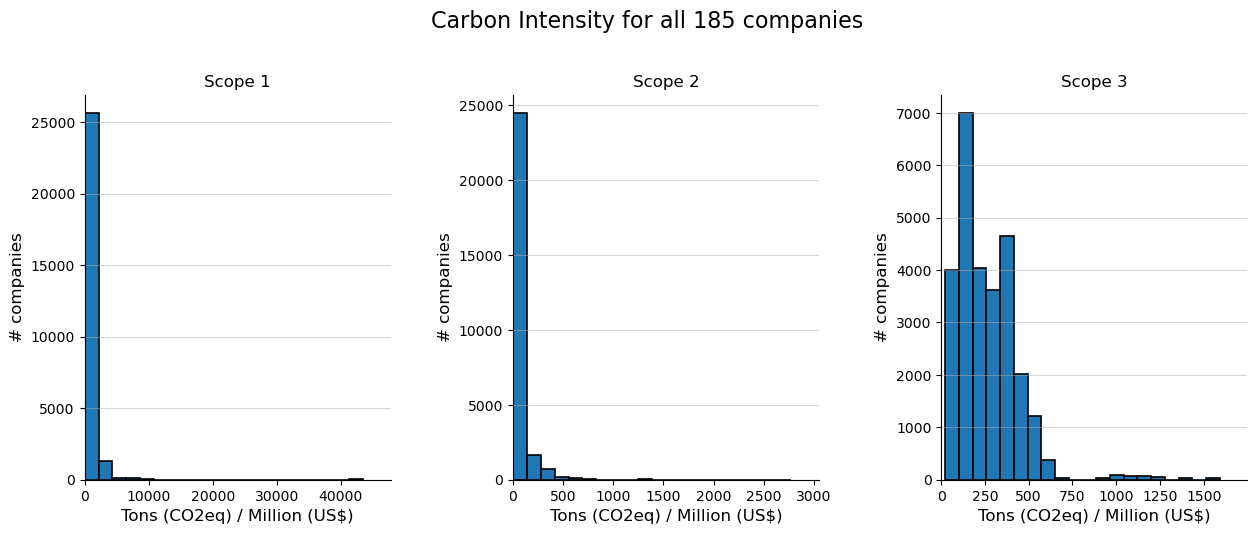

In [206]:

def get_hist_plot(data: pd.DataFrame, columns: list[str], title='Histogram', color=None):
    '''
    Function that creates a histogram plot on the given data for the given columns.
    xticks_rotation: rotation of xticks in degrees
    '''
    fig, axs = plt.subplots(nrows=1, ncols=len(columns), figsize=(15, 5))

    # Plot each set of data in a different subplot
    for i, col in enumerate(columns):
        # Calculate x-limits based on data in the column
        x_min = data[col].min()
        x_max = data[col].max()
        x_range = x_max - x_min
        x_min = max(0, x_min - 0.1 * x_range)
        x_max += 0.1 * x_range
        axs[i].hist(data[col], bins=20, edgecolor='black', linewidth=1.2, color=color)
        axs[i].set_xlim([x_min, x_max])
        axs[i].set_title(col.replace('_', ' '), fontsize=12)
        axs[i].set_xlabel('Tons (CO2eq) / Million (US$)', fontsize=12)
        axs[i].set_ylabel('# companies', fontsize=12)
        axs[i].tick_params(axis='both', which='major', labelsize=10)
        axs[i].grid(axis='y', alpha=0.5)
        axs[i].spines['right'].set_visible(False)
        axs[i].spines['top'].set_visible(False)
    fig.suptitle(title, fontsize=16, y=1.05)
    # Increase spacing between subplots
    fig.subplots_adjust(wspace=0.4)
    return plt

get_hist_plot(data=df_nrg_intensity, columns=scopes, title='Carbon Intensity for all 185 companies').show()


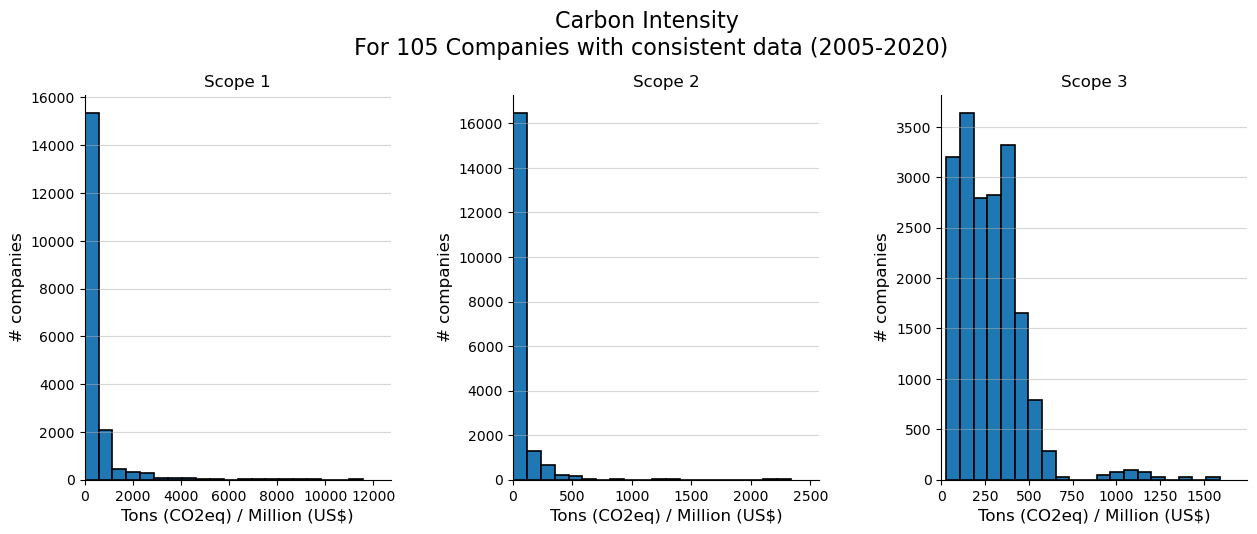

In [149]:
get_hist_plot(data=df_nrg_intensity_all_years, columns=scopes, title='Carbon Intensity\n For 105 Companies with consistent data (2005-2020)').show()



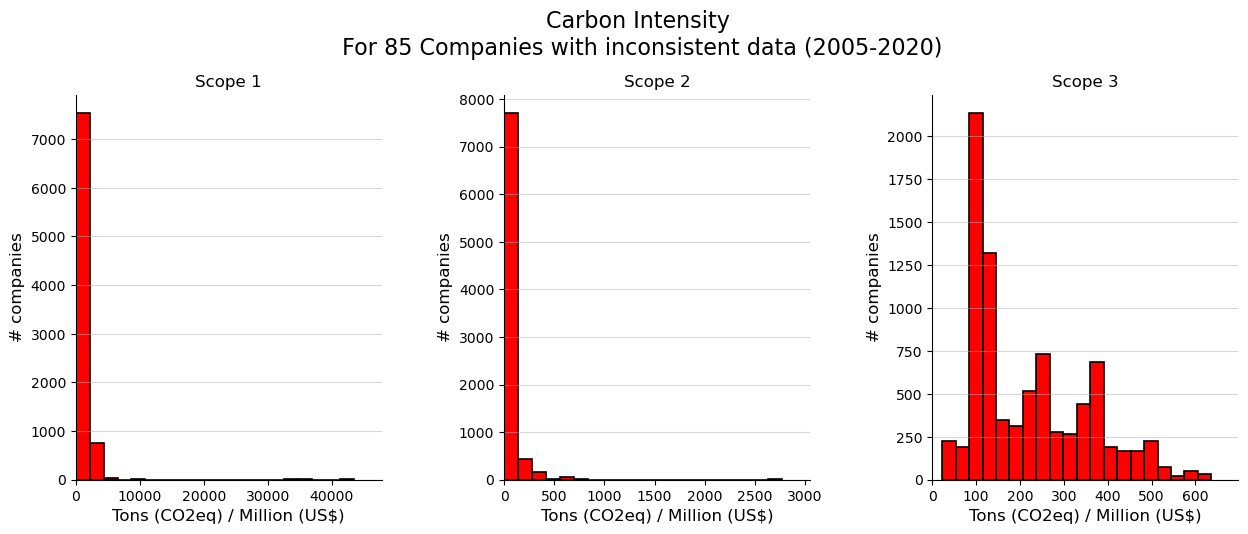

In [150]:
q1_inconsistent_graph = get_hist_plot(data=df_nrg_intensity_corrupt, columns=scopes, title='Carbon Intensity\n For 85 Companies with inconsistent data (2005-2020)', color='red')
q1_inconsistent_graph.show()

### Q2

In Question 4 of Homework 1, you calculated efficient portfolios with various target returns. Take these portfolios, calculate and report the weighted-average E/S/G score or weighted-average carbon intensity of these portfolios (you can take the average score/carbon intensity for each firm over time). Comment on the E/S/G score or carbon intensity of the portfolios. Which firms (e.g. top 10; report firm names along with ISIN) are driving the E/S/G score down or driving the carbon intensity up? Plot on the volatility-E/S/G score (carbon intensity) space the various portfolios (i.e., make a plot similar to the efficient frontier except that E/S/G score or carbon intensity replaces the return on the y-axis). (15 points)



### Q3

This question is a follow-up of Question 7 of Homework 1. First, take the same 100 selected firms. Then, create a minimum variance portfolio with monthly rebalancing with an additional constraint: you exclude the worst firms in terms of E/S/G score/most polluting (high carbon intensity) firms. Specifically, exclude the bottom tercile of the distribution in month t − 1 for ESG scores or exclude the top tercile of the distribution in month t − 1 for the carbon intensity. Report summary statistics on the performance (return, risk, Sharpe ratio) of this portfolio as well as its E/S/G score or carbon intensity. How do the performance measures (return, risk, Sharpe ratio) compare with the minimum variance portfolio from Question 3 of Homework 1. (20 points)

### Q4 

For each month, sort firms based on your group’s variable of interest (E/S/G scores or carbon intensity) into quintiles. Create equally-weighted and value-weighted portfolios for each time period and each score or carbon intensity quintile. Report the average returns for each quintile portfolio as well as a portfolio that goes long in the highest quintile and short the lowest quintile. Comment on your results. What can explain the relationship between the return of your portfolios and firms’ ESG score or carbon emissions? (25 points)

### Q5

Take the minimum variance portfolio from Question 3 of Homework 1 and calculate its E/S/G score or carbon intensity. Reallocate its composition in order to improve the E/S/G score by 20%/reduce carbon intensity by 50% (see optimization problem below). Comment on the changes it took in order to improve the ESG score/carbon intensity (e.g., how many and which firms (firm names) had to be removed in the most recent year of your sample in order to achieve these objectives). (30 points)

$$\min_{\alpha} \quad \alpha' \sum{\alpha}$$
$$\text{s.a.} \quad \alpha' e = 1$$
$$\quad \quad \alpha'\text{CI} \leq 0.5 \times \left( \alpha' CI \right)_{Q3-Homework1}$$